# Classifying German Credit Risk

With the dataset from https://www.kaggle.com/uciml/german-credit.

We are given age, sex, job type, housing type, the size of savings and checking accounts, loan size, loan duration, purpose, and whether or not the individual defaulted on the loan.

The set contains data for 1000 individuals. The savings and checking columns have missing data. There are 817 with only savings account information, and 606 with only checking data. Some are missing both, so we only have complete data for 522 individuals.

Given this data, we will attempt to create a risk assessment model to predict whether a lender will default. Many potentially important datum are notable in their absence: we don't have previous payments, interest rates, income information, previous defaults, etc.

Contents:

<ul>
<li><a href='#exp'>Exploratory analysis</a> - visualizations and correlations</li>
<li><a href='#ageclass'>Age binning</a> - age may be more useful as groupings, so we'll need to bin ages.</li>
<li><a href='#prelimrisk'>Preliminary risk classification</a> - using only the 522 individuals with complete data.</li>
<li><a href='#advrisk'>More advanced classification</a> - try to fill in some blanks before trying to classify risk again.</li>
</ul>

In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import linregress
from scipy import linalg
from scipy.spatial.distance import cdist
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.grid_search import GridSearchCV 
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
%matplotlib inline

In [31]:
df = pd.read_csv('german_credit_data.csv',index_col=0)
# In thousands of DM
df['Credit amount'] = df['Credit amount']*0.001
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1.169,6,radio/TV,good
1,22,female,2,own,little,moderate,5.951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2.096,12,education,good
3,45,male,2,free,little,little,7.882,42,furniture/equipment,good
4,53,male,2,free,little,little,4.870,24,car,bad


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
Age                 1000 non-null int64
Sex                 1000 non-null object
Job                 1000 non-null int64
Housing             1000 non-null object
Saving accounts     817 non-null object
Checking account    606 non-null object
Credit amount       1000 non-null float64
Duration            1000 non-null int64
Purpose             1000 non-null object
Risk                1000 non-null object
dtypes: float64(1), int64(3), object(6)
memory usage: 85.9+ KB


In [33]:
print('Sex categories: {}'.format(df['Sex'].unique()))
print('Job categories: {}'.format(df['Job'].unique()))
print('Housing categories: {}'.format(df['Housing'].unique()))
print('Savings categories: {}'.format(df['Saving accounts'].unique()))
print('Checking categories: {}'.format(df['Checking account'].unique()))
print('Purpose categories: {}'.format(df['Purpose'].unique()))
print('Risk categories: {}'.format(df['Risk'].unique()))

Sex categories: ['male' 'female']
Job categories: [2 1 3 0]
Housing categories: ['own' 'free' 'rent']
Savings categories: [nan 'little' 'quite rich' 'rich' 'moderate']
Checking categories: ['little' 'moderate' nan 'rich']
Purpose categories: ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
Risk categories: ['good' 'bad']


If so desired, we can convert all of the categoricals into integers, but for now we only need to do Risk.

In [34]:
# This is needlessly complicated, but the structure is much more useful for a larger number of mappings, which will
# be the case later.
risk_dict = {'Risk':{'bad':1,'good':0}}
dfd = df.copy()
for i,v in enumerate (df):
    if v in risk_dict.keys():
        dfd[v]=dfd[v].map(risk_dict[v])

<a id='exp'></a>
## Exploratory analysis

Let's try to find relationships between the predictors and risk, as well as with each other. First, we see that 30% of our observations defaulted.

In [35]:
dfd.groupby('Risk').count()['Age']

Risk
0    700
1    300
Name: Age, dtype: int64

Text(0.5,1,'Average risk of default for females and males')

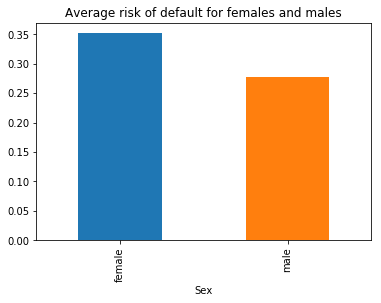

In [36]:
dfd.groupby('Sex').describe()['Risk']['mean'].plot(kind='bar')
plt.title('Average risk of default for females and males')

Men are better at repaying loans than women, and we'll look at the specifics further down.

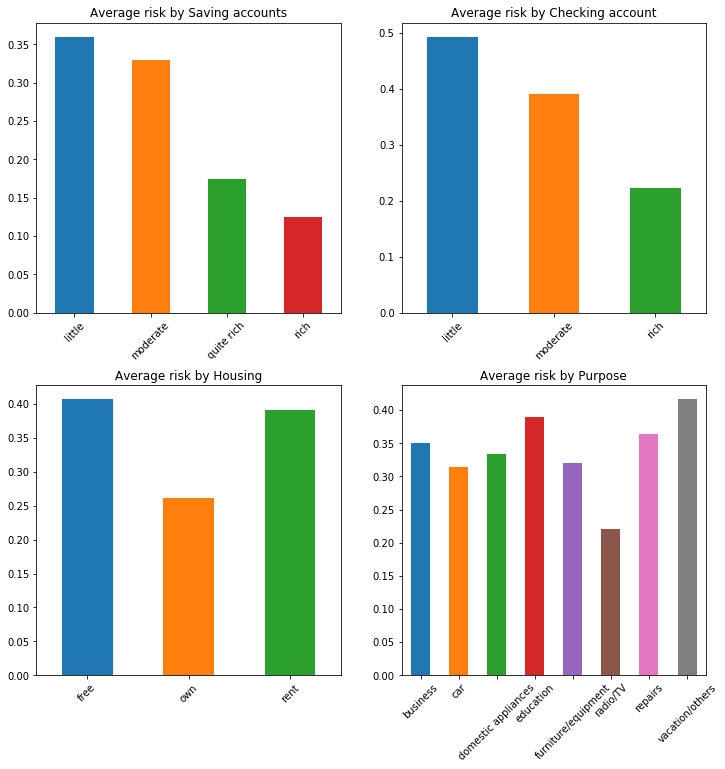

In [37]:
l = ['Saving accounts','Checking account','Housing','Purpose']
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

for i in range(4):
    plt.subplot(2,2,i+1)
    dfd.groupby(l[i]).describe()['Risk']['mean'].plot(kind='bar')
    plt.title('Average risk by '+l[i])
    plt.xticks(rotation=45)
    plt.xlabel('')

plt.subplots_adjust(hspace=0.25)

As we might expect, creditworthiness increases with the amount of money in savings and checking accounts. Homeowners have better credit than renters. Radio/tv is the most credit-worthy purpose, while vacation/other is the least.

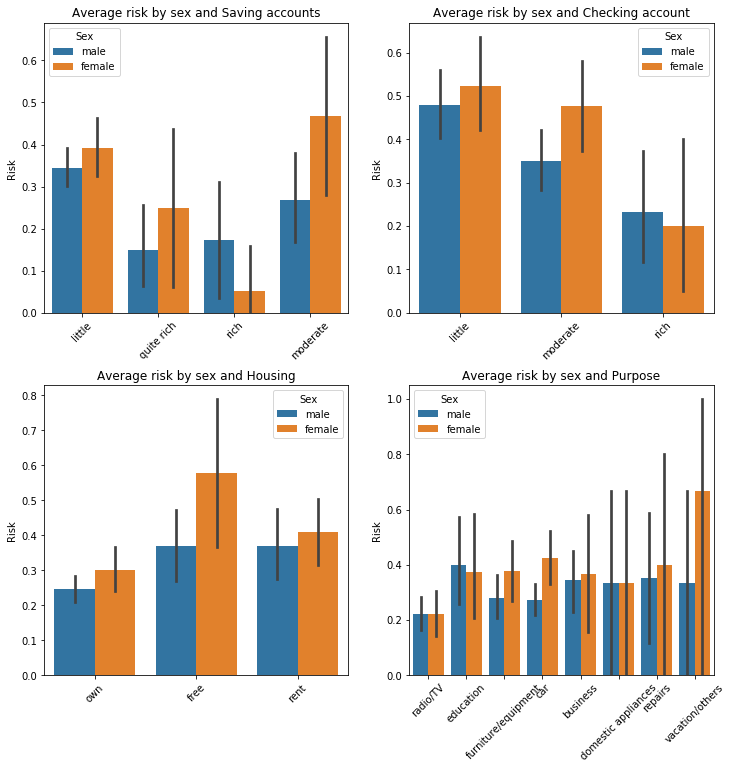

In [38]:
l = ['Saving accounts','Checking account','Housing','Purpose']
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

for i in range(4):
    plt.subplot(2,2,i+1)
    sns.barplot(x=l[i], y='Risk', hue='Sex', data=dfd)
    plt.title('Average risk by sex and '+l[i])
    plt.xticks(rotation=45)
    plt.xlabel('')

plt.subplots_adjust(hspace=0.25)

It looks like males tend to have better credit across the board, except when it comes to education loans and in the highest bank account categories. Notably, women are better than men at repaying education loans, but much worse at repaying vacation/other loans.

However, it may be worth examining the types of loans taken by people in different wealth categories.

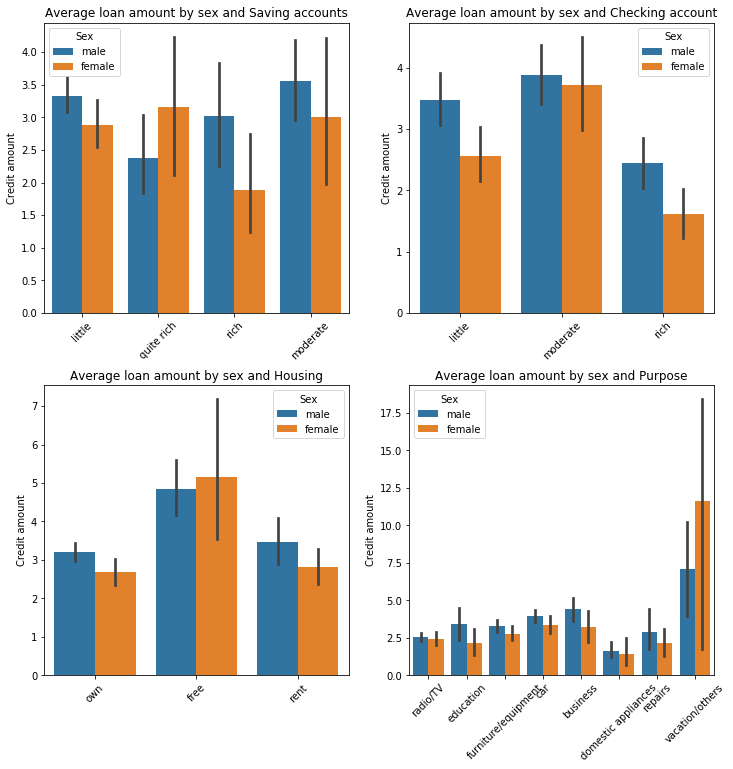

In [39]:
l = ['Saving accounts','Checking account','Housing','Purpose']
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

for i in range(4):
    plt.subplot(2,2,i+1)
    sns.barplot(x=l[i], y='Credit amount', hue='Sex', data=dfd)
    plt.title('Average loan amount by sex and '+l[i])
    plt.xticks(rotation=45)
    plt.xlabel('')

plt.subplots_adjust(hspace=0.25)

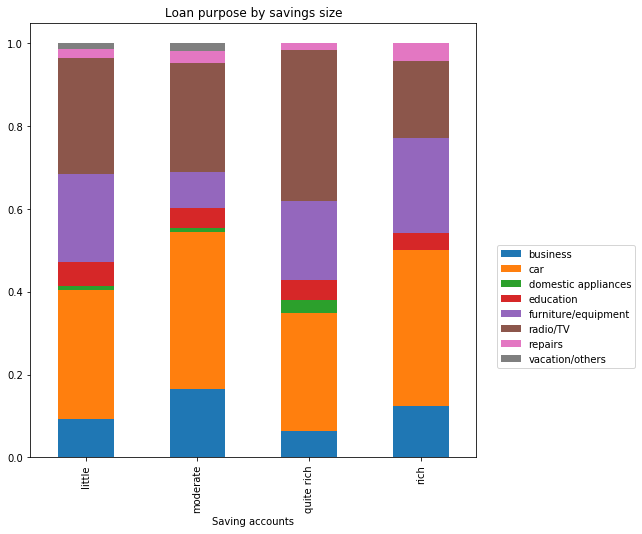

In [40]:
fig,ax=plt.subplots(figsize=(8,8))
pd.crosstab(index=dfd['Saving accounts'], columns=dfd['Purpose'],normalize='index').plot(kind='bar',stacked=True,ax=plt.subplot(1,1,1))
plt.title('Loan purpose by savings size')
plt.legend(loc=9, bbox_to_anchor=(1.2,0.5))

People with more in the bank tend to borrow less than others, although people with 'moderate' amounts tend to borrow more than those with 'little' in the bank.

We can also spot the inverse relationship between the size of the loan and creditworthiness. We noted above that women tended to be better at repaying education loans and worse with vacations. Now we can see that their education loans tend to be significantly smaller, and vacation loans significantly larger.

In general, defaulted loans tend to be larger, and men borrow more than women. We can also see that the duration and loan amount plots have similar shapes, since there is a correlation between loan size and loan duration.

Text(0.5,1,'Average duration for bad and good risk')

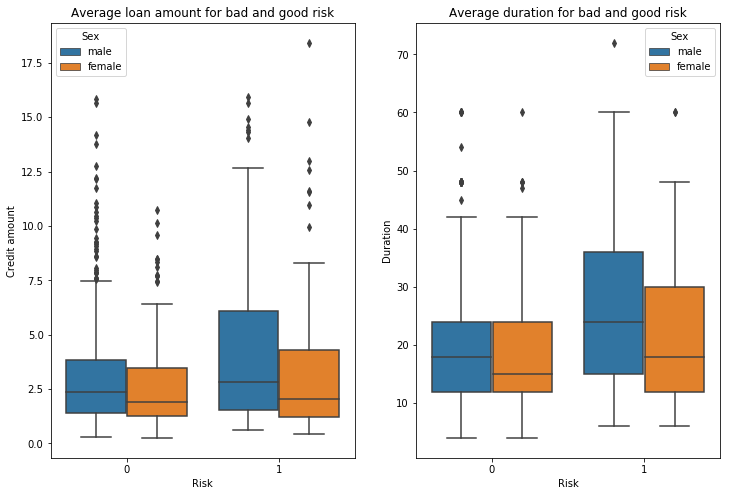

In [41]:
fig,ax=plt.subplots(ncols=2, figsize=(12,8))
plt.subplot(1,2,1)
sns.boxplot(x='Risk', y='Credit amount', hue='Sex', data=dfd)
plt.title('Average loan amount for bad and good risk')

plt.subplot(1,2,2)
sns.boxplot(x='Risk', y='Duration', hue='Sex', data=dfd)
plt.title('Average duration for bad and good risk')

In [42]:
dfd[['Credit amount','Duration']].corr()

,Credit amount,Duration
Credit amount,1.000000,0.624984
Duration,0.624984,1.000000


We can go even further and see that duration is a statistically significant estimator of loan size (and this implies the reverse is true as well). In a no constant model, it's even a decent fit with an $R^2$ of 0.74. If for whatever reason there was missing  amount or duration data, we would have a pretty good basis for filling in the blanks.

In [43]:
X = dfd['Duration']
y = dfd['Credit amount']

lm=sm.OLS(y,X)
lm.fit(cov_type='HC0').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Credit amount   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     1642.
Date:                Thu, 04 Jan 2018   Prob (F-statistic):          4.48e-213
Time:                        11:17:43   Log-Likelihood:                -2209.7
No. Observations:                1000   AIC:                             4421.
Df Residuals:                     999   BIC:                             4426.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Duration       0.1540      0.004     40.516      0.000       0.147       0.161
==============================================================================
Omnibus:                      387.584   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1874.679
Skew:                           1.748   Prob(JB):                         0.00
Kurtosis:                       8.725   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

Text(0.5,1,'Loan duration vs amount')

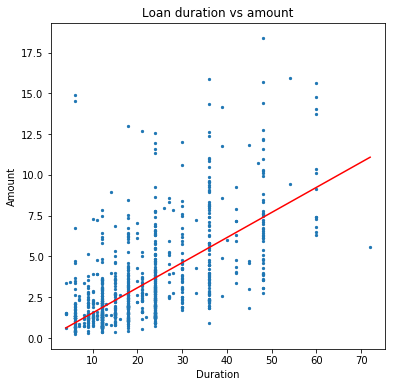

In [44]:
plt.figure(figsize=(6,6))
plt.scatter(X,y,s=5)
# A no intercept model is just y = aX, where a is the sole coefficient
plt.plot(np.unique(X),np.unique(X)*lm.fit().params[0],'r')
plt.xlabel('Duration')
plt.ylabel('Amount')
plt.title('Loan duration vs amount')

There is a pretty stong relationship, but it does not look like we need to worry about collinearity.

Most relationships between the variables are not quite so linear.

Text(0.5,0,'')

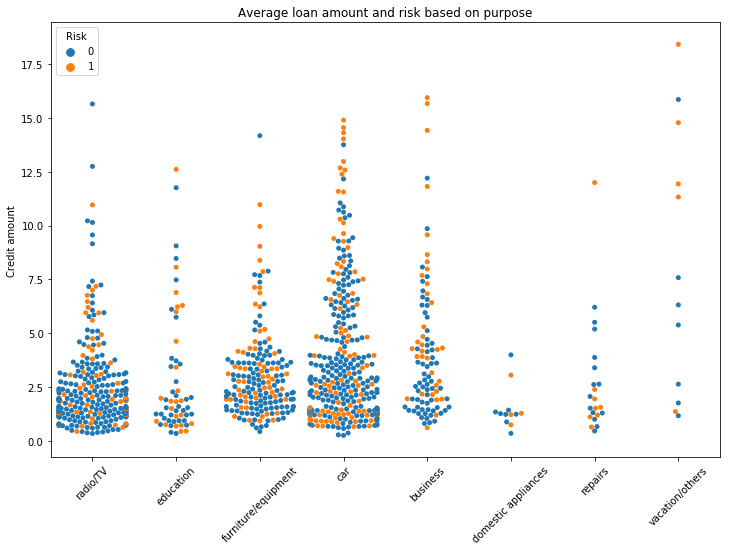

In [45]:
plt.figure(figsize=(12,8))
sns.swarmplot(x='Purpose', y='Credit amount', hue='Risk', data=dfd)
plt.title('Average loan amount and risk based on purpose')
plt.xticks(rotation=45)
plt.xlabel('')

In [46]:
dfd.groupby('Risk')['Credit amount'].describe()

,count,mean,std,min,25%,50%,75%,max
Risk,,,,,,,,
0,700.0,2.985457,2.401472,0.250,1.3755,2.2440,3.63475,15.857
1,300.0,3.938127,3.535819,0.433,1.3525,2.5745,5.14150,18.424


Unsurprisingly, defaulted loans are noticeably larger than good loans, while business loans and vacation/other loans are under the highest risk of default. We can see that with a single exception, all of the defaulted vacation loans are in the upper half of loan amounts.

Overall, defaulted loans are on average DM1000 larger than paid-off loans.

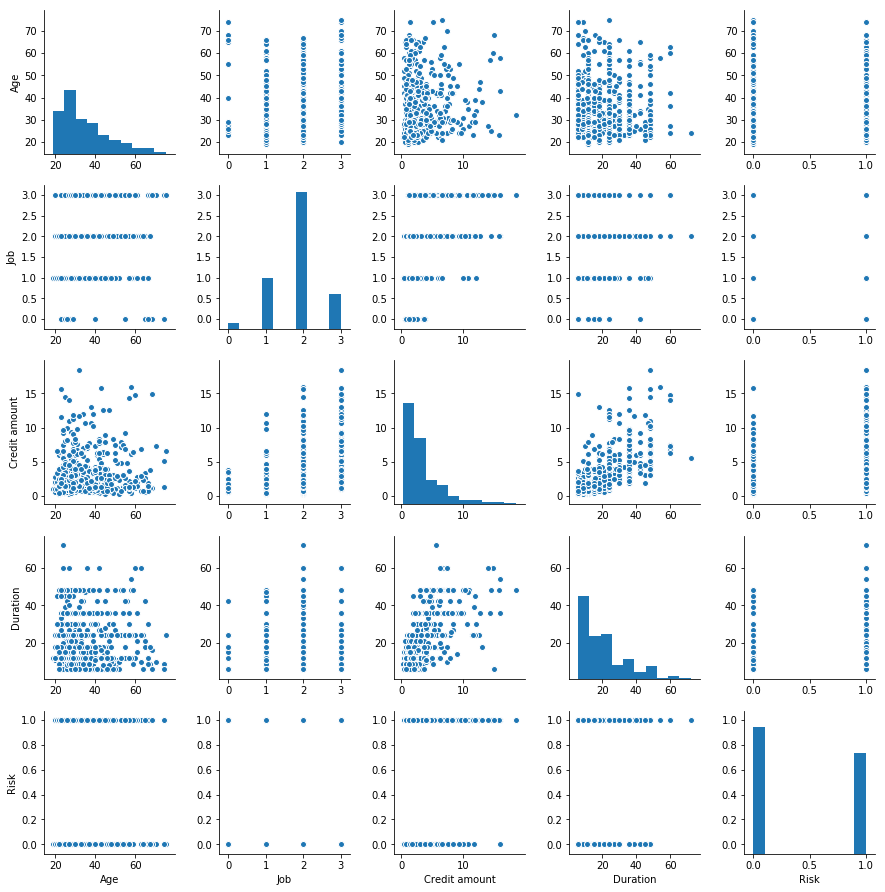

In [47]:
sns.pairplot(dfd.dropna())

In general, there does not seem to be a strong correlation between age and bank account amounts. There is a clear correlation between loan duration and loan ammount, and both have some positive relation to defaulting.

We can also look at the relationship between the two different types of bank accounts. Most people have 'little' savings, and even those with 'rich' checking accounts have small savings. However, those with moderate checking are more likely to have moderate savings, and the same with rich checking and rich savings.

The other way around, those with little savings also tend to have little in their checking account. Anyone with more in their savings will tend to have moderate checking accounts. Interestingly, the richest in savings tend to have smaller checking accounts than those with only quite rich savings. Perhaps the richest are more likely to invest more of their money.

In [48]:
print(dfd.groupby('Saving accounts').count()['Risk'])
print(dfd.groupby('Checking account').count()['Risk'])

Saving accounts
little        603
moderate      103
quite rich     63
rich           48
Name: Risk, dtype: int64
Checking account
little      274
moderate    269
rich         63
Name: Risk, dtype: int64


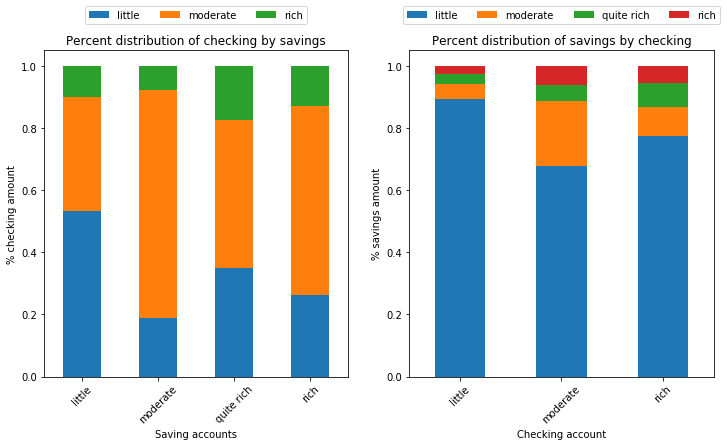

In [49]:
fig,ax = plt.subplots(ncols=2,figsize=(12,6))

pd.crosstab(index=dfd['Saving accounts'],columns=dfd['Checking account'], normalize='index').plot(kind='bar',stacked=True, ax=plt.subplot(1,2,1))
plt.legend(loc='upper left')
plt.title('Percent distribution of checking by savings')
plt.ylabel('% checking amount')
plt.xticks(rotation=45)
plt.legend(loc=9, bbox_to_anchor=(0.5,1.15), ncol=len(set(dfd['Checking account'])))

pd.crosstab(index=dfd['Checking account'],columns=dfd['Saving accounts'], normalize='index').plot(kind='bar',stacked=True, ax=plt.subplot(1,2,2))
plt.legend(loc='upper left')
plt.title('Percent distribution of savings by checking')
plt.ylabel('% savings amount')
plt.xticks(rotation=45)
plt.legend(loc=9, bbox_to_anchor=(0.5,1.15), ncol=len(set(dfd['Saving accounts'])))

The relationship between saving and checking accounts is not linear. Generally there is a tradeoff: even those with large savings accounts have on average less than moderate savings, and those with large checking accounts have significantly less than moderate savings.

<a id='ageclass'></a>
## Dealing with Age

We want to bin age, but we need to see its relationships with other variables, starting with the bank account classifiers. If we want to be very technical, age is already binned by being discretized into whole years, but there is a very uneven distribution of observations among different ages. In any case, maybe we can group them in a more useful way.

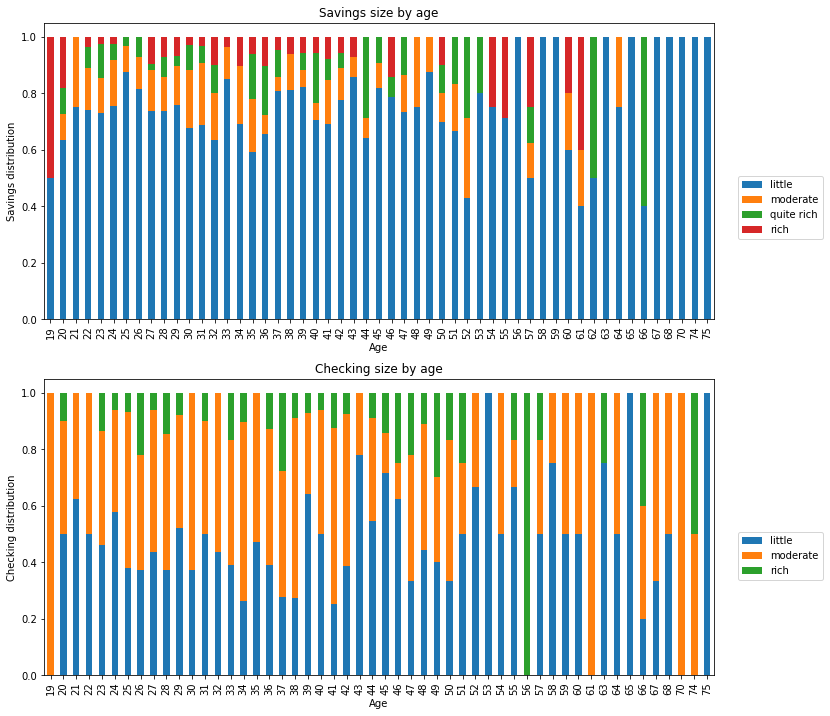

In [21]:
fig,ax = plt.subplots(nrows=2,figsize=(12,12))
pd.crosstab(index=dfd['Age'],columns=dfd['Saving accounts'],normalize='index').plot(kind='bar',stacked=True,ax=plt.subplot(2,1,1))
plt.ylabel('Savings distribution')
plt.title('Savings size by age')
plt.legend(loc=9, bbox_to_anchor=(1.1,0.5))

pd.crosstab(index=dfd['Age'],columns=dfd['Checking account'],normalize='index').plot(kind='bar',stacked=True,ax=plt.subplot(2,1,2))
plt.ylabel('Checking distribution')
plt.title('Checking size by age')
plt.legend(loc=9, bbox_to_anchor=(1.1,0.5))

In the general population, but here we're dealing with relatively small loans with an average less than 4000 Deutsche Marks and a maximum less than 20,000 (In 1995, $1 USD was worth around 1.4 DEM), so we don't really see a clear relation here. At least not by looking at ages individually.

The amount of loans is something else we can look at.

In [50]:
# Let's quantify everything now
conversion_dict = {'Sex':{'male':0, 'female':1},
                   'Housing':{'free':0,'rent':1,'own':2},
                   'Saving accounts':{'little':0,'moderate':1,'quite rich':2,'rich':3},
                   'Checking account':{'little':0,'moderate':1,'rich':2},
                   'Purpose':{'radio/TV':0,'education':1,'furniture/equipment':2,'car':3,'business':4,
                             'domestic appliances':5,'repairs':6,'vacation/others':7},
                   'Risk':{'bad':1,'good':0}}

df_age = df.copy()

for i,v in enumerate(df):
    if v in conversion_dict.keys():
        df_age[v]=df_age[v].map(conversion_dict[v])

Text(0.5,1,'Total loans by age')

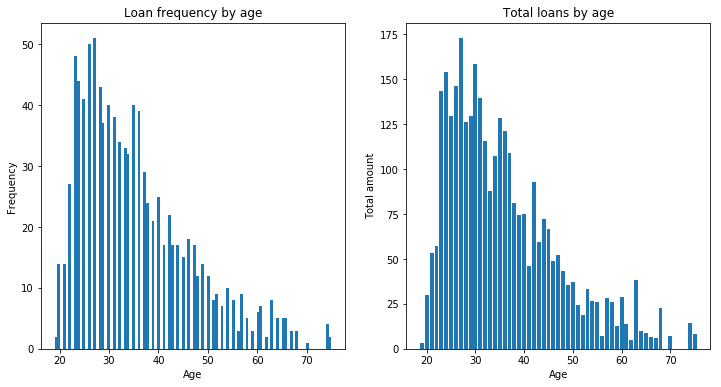

In [51]:
fig,ax=plt.subplots(ncols=2, figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(df_age['Age'],bins=100)
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.title('Loan frequency by age')

plt.subplot(1,2,2)
plt.bar(list(set(df_age['Age'])), df_age.groupby('Age').agg(np.sum)['Credit amount'])
plt.ylabel('Total amount')
plt.xlabel('Age')
plt.title('Total loans by age')

This looks pretty promising, and we can see that most loans were made to people aged 23-36. We will bin the ages into quartiles.

In [52]:
freq=pd.DataFrame(sorted(df_age['Age']))
freq.quantile(q=[0.25,0.5,0.75])

,0
0.25,27.0
0.50,33.0
0.75,42.0


We can see that half of all loans are given to borrowers 33 or under.

In [53]:
dfd['Age_category'] = np.digitize(np.array(df_age['Age']),np.array([0,27,33,42,100]))
dfd.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_category
0,67,male,2,own,NaN,little,1.169,6,radio/TV,0,4
1,22,female,2,own,little,moderate,5.951,48,radio/TV,1,1
2,49,male,1,own,little,NaN,2.096,12,education,0,4
3,45,male,2,free,little,little,7.882,42,furniture/equipment,0,4
4,53,male,2,free,little,little,4.870,24,car,1,4


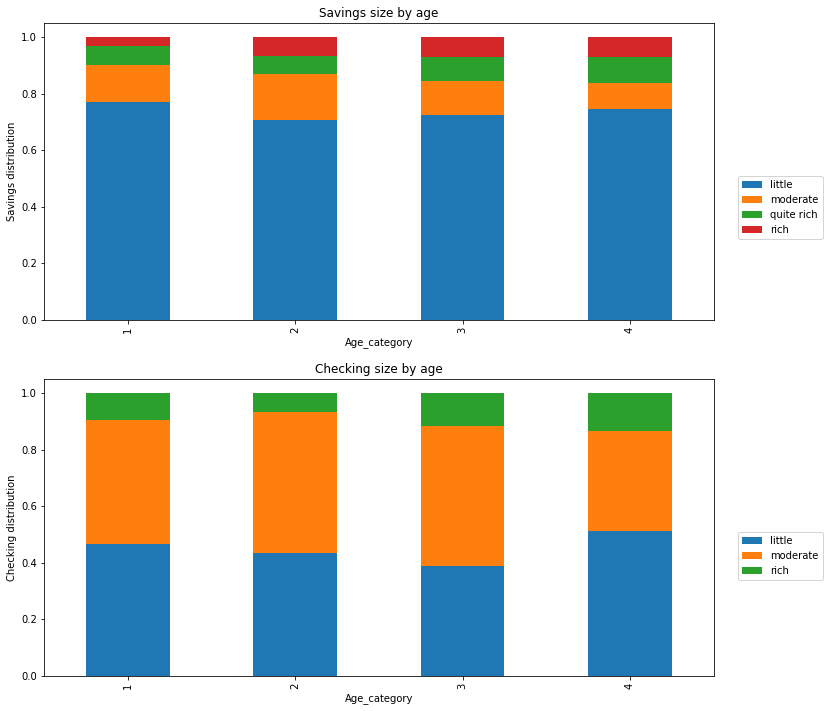

In [54]:
fig,ax = plt.subplots(nrows=2,figsize=(12,12))
pd.crosstab(index=dfd['Age_category'],columns=dfd['Saving accounts'],normalize='index').plot(kind='bar',stacked=True,ax=plt.subplot(2,1,1))
plt.ylabel('Savings distribution')
plt.title('Savings size by age')
plt.legend(loc=9, bbox_to_anchor=(1.1,0.5))

pd.crosstab(index=dfd['Age_category'],columns=dfd['Checking account'],normalize='index').plot(kind='bar',stacked=True,ax=plt.subplot(2,1,2))
plt.ylabel('Checking distribution')
plt.title('Checking size by age')
plt.legend(loc=9, bbox_to_anchor=(1.1,0.5))

We can now see that the relative amont of little checking accounts decreases with aging, at least until 42. The 42+ category has the greatest proportion of both rich and little checking accounts.

With savings, there seems to be some growth in quite rich accounts with higher ages, but the number of rich accounts remains fairly constant.

<a id='prelimrisk'></a>
## Preliminary Classification

Now let's try to create a model for default risk.

### Dummy variables
We need to turn Job, Housing, Savings, Checking and Purpose into categorical variables. Sex and risk are fine since they are binary categories.

The default, with all categorical variables set to 0, is a woman working an unskilled job, living in free housing, with little savings or checking, borrowing money to buy a radio or TV.

In [218]:
def dummify(df, col):
    dummies=pd.get_dummies(df[col], prefix=col, drop_first=True)
    df = pd.concat((df,dummies),axis=1)
    return df

In [219]:
dff = dfd.copy()

In [220]:
dff = dummify(dff,'Sex')
dff = dummify(dff,'Job')
dff = dummify(dff,'Housing')
dff = dummify(dff,'Saving accounts')
dff = dummify(dff,'Checking account')
dff = dummify(dff,'Purpose')
dff = dummify(dff,'Age_category')

In [221]:
dff.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk', 'Age_category',
       'Sex_male', 'Job_1', 'Job_2', 'Job_3', 'Housing_own', 'Housing_rent',
       'Saving accounts_moderate', 'Saving accounts_quite rich',
       'Saving accounts_rich', 'Checking account_moderate',
       'Checking account_rich', 'Purpose_car', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Purpose_repairs', 'Purpose_vacation/others', 'Age_category_2',
       'Age_category_3', 'Age_category_4'],
      dtype='object')

First, let's see the predictive power of just age, sex, job, housing, credit amount, duration and purpose (where we have complete data for all 1000 individuals).

In [222]:
X = dff[['Credit amount', 'Duration',
       'Sex_male', 'Job_1', 'Job_2', 'Job_3', 'Housing_own', 'Housing_rent',
       'Purpose_car', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Purpose_repairs', 'Purpose_vacation/others', 'Age_category_2',
       'Age_category_3', 'Age_category_4']]
y = dff['Risk']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.35, random_state=10101)

In [224]:
logit = LogisticRegressionCV()
logit.fit(X_train,y_train)
print('TRAINING DATA')
print(classification_report(y_train,logit.predict(X_train)))
print('TEST DATA')
print(classification_report(y_test,logit.predict(X_test)))

TRAINING DATA
             precision    recall  f1-score   support

          0       0.72      0.96      0.83       456
          1       0.60      0.13      0.22       194

avg / total       0.69      0.72      0.64       650

TEST DATA
             precision    recall  f1-score   support

          0       0.72      0.93      0.81       244
          1       0.52      0.16      0.24       106

avg / total       0.66      0.70      0.64       350



As is usually the case in credit classification problems, random forest vastly overfits the training data. If we set the number of estimators high enough, it is possible to get 100% precision and recall. Gradient boosting overfits as well but not to the same extent.

In [69]:
rfr = RandomForestClassifier(random_state = 10101)
rfr.fit(X_train,y_train)
print('TRAINING DATA')
print(classification_report(y_train,rfr.predict(X_train)))
print('TEST DATA')
print(classification_report(y_test,rfr.predict(X_test)))

TRAINING DATA
             precision    recall  f1-score   support

          0       0.95      0.98      0.97       456
          1       0.96      0.88      0.92       194

avg / total       0.95      0.95      0.95       650

TEST DATA
             precision    recall  f1-score   support

          0       0.73      0.81      0.77       244
          1       0.40      0.29      0.34       106

avg / total       0.63      0.65      0.64       350



In [80]:
grad = GradientBoostingClassifier(random_state=10101)
grad.fit(X_train,y_train)
print('TRAINING DATA')
print(classification_report(y_train,grad.predict(X_train)))
print('TEST DATA')
print(classification_report(y_test,grad.predict(X_test)))

TRAINING DATA
             precision    recall  f1-score   support

          0       0.84      0.98      0.91       456
          1       0.93      0.56      0.70       194

avg / total       0.87      0.86      0.84       650

TEST DATA
             precision    recall  f1-score   support

          0       0.73      0.85      0.78       244
          1       0.44      0.26      0.33       106

avg / total       0.64      0.67      0.65       350



As we saw before, there is a correlation between larger bank accounts and creditworthiness, so we should find a way to estimate savings and checking account sizes.

This is made more difficult by the fact that there are 99 individuals for which we have neither savings nor checking infomation.

In [81]:
dff[(dff['Saving accounts'].isnull()) & (dff['Checking account'].isnull())].count()

Age                            99
Sex                            99
Job                            99
Housing                        99
Saving accounts                 0
Checking account                0
Credit amount                  99
Duration                       99
Purpose                        99
Risk                           99
Age_category                   99
Sex_male                       99
Job_1                          99
Job_2                          99
Job_3                          99
Housing_own                    99
Housing_rent                   99
Saving accounts_moderate       99
Saving accounts_quite rich     99
Saving accounts_rich           99
Checking account_moderate      99
Checking account_rich          99
Purpose_car                    99
Purpose_domestic appliances    99
Purpose_education              99
Purpose_furniture/equipment    99
Purpose_radio/TV               99
Purpose_repairs                99
Purpose_vacation/others        99
Age_category_2

First, create a model with only the 522 complete individuals.

In [82]:
dff2 = dff.dropna()
dff2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522 entries, 1 to 999
Data columns (total 32 columns):
Age                            522 non-null int64
Sex                            522 non-null object
Job                            522 non-null int64
Housing                        522 non-null object
Saving accounts                522 non-null object
Checking account               522 non-null object
Credit amount                  522 non-null float64
Duration                       522 non-null int64
Purpose                        522 non-null object
Risk                           522 non-null int64
Age_category                   522 non-null int64
Sex_male                       522 non-null uint8
Job_1                          522 non-null uint8
Job_2                          522 non-null uint8
Job_3                          522 non-null uint8
Housing_own                    522 non-null uint8
Housing_rent                   522 non-null uint8
Saving accounts_moderate       522 non

In [85]:
X=dff2[['Sex_male','Credit amount','Duration','Job_1','Job_2','Job_3','Housing_own','Housing_rent',
    'Saving accounts_moderate','Saving accounts_quite rich','Saving accounts_rich',
    'Checking account_moderate', 'Checking account_rich',
    'Purpose_car','Purpose_domestic appliances','Purpose_education','Purpose_furniture/equipment',
    'Purpose_radio/TV','Purpose_repairs','Purpose_vacation/others','Age_category_2','Age_category_3',
    'Age_category_4']]
y=dff2['Risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=10101)

Logistic regression

In [88]:
logit = LogisticRegressionCV()
logit.fit(X_train,y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=10101,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [92]:
print('TRAINING DATA')
print(classification_report(y_train,logit.predict(X_train)))
print('TEST DATA')
print(classification_report(y_test,logit.predict(X_test)))
print('TEST ACCURACY')
print(accuracy_score(y_test,logit.predict(X_test)))

TRAINING DATA
             precision    recall  f1-score   support

          0       0.62      0.89      0.73       182
          1       0.75      0.38      0.50       157

avg / total       0.68      0.65      0.63       339

TEST DATA
             precision    recall  f1-score   support

          0       0.62      0.73      0.67       109
          1       0.46      0.34      0.39        74

avg / total       0.56      0.57      0.56       183

TEST ACCURACY
0.573770491803


In [167]:
logit=sm.Logit(y_train,X_train)
print(logit.fit().summary())

Optimization terminated successfully.
         Current function value: 0.590563
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   Risk   No. Observations:                  339
Model:                          Logit   Df Residuals:                      316
Method:                           MLE   Df Model:                           22
Date:                Thu, 04 Jan 2018   Pseudo R-squ.:                  0.1446
Time:                        04:06:44   Log-Likelihood:                -200.20
converged:                       True   LL-Null:                       -234.05
                                        LLR p-value:                 1.511e-06
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Sex_male                       -0.3544      0.274     -1.292      0.196   

40%+ error is pretty high, so there's a lot of work to be done. Individually, loan duration and having high savings and checking account balances have the most statistical significance. But that is highly dependent on how the data is split. So let's cross validate using k=10 folds.

In [106]:
logit = LogisticRegressionCV()
pred = cross_val_predict(logit, X, y, cv=10)
print ('TEST F1')
print (classification_report(y, pred))
print ('TEST ACCURACY')
print (accuracy_score(y, pred))

TEST F1
             precision    recall  f1-score   support

          0       0.64      0.78      0.70       291
          1       0.61      0.44      0.51       231

avg / total       0.63      0.63      0.62       522

TEST ACCURACY
0.628352490421


Random forest with default settings gives us comparable results to logit on the test data, despite being incredibly high on the training data.

In [126]:
n = 100
acc_sum = 0
for i in range(n):
    rfr = RandomForestClassifier()
    pred = cross_val_predict(rfr, X, y, cv=10)
    acc_sum += accuracy_score(y,pred)
print ('AVERAGE TEST ACCURACY OVER ', n , ' RANDOM FORESTS')
print (acc_sum/n)

AVERAGE TEST ACCURACY OVER  100  RANDOM FORESTS
0.620498084291


Gradient boosting seems to give better results on test data.

MEAN ACCURACY:  0.682681992337


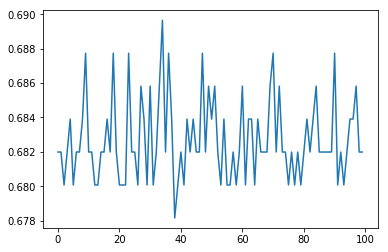

In [132]:
n=100
acc_array_grad=[]
for i in range(n):
    grad = GradientBoostingClassifier()
    acc_array_grad.append(accuracy_score(y,cross_val_predict(grad, X, y, cv=10)))
plt.plot(range(n),acc_array_grad)
print('MEAN ACCURACY: ', np.mean(acc_array_grad))

The exclusion of all missing data meant that we cut our sample size in half, and so we are still stuck in the 0.60s in terms of predictive power.

In [146]:
grad = GradientBoostingClassifier(random_state = 10101)
pred = cross_val_predict(grad, X, y, cv=10)
print ('TEST F1')
print (classification_report(y, pred))
print ('TEST CONFUSION MATRIX')
print (confusion_matrix(y,pred))
print ('TEST ACCURACY')
print (accuracy_score(y, pred))

TEST F1
             precision    recall  f1-score   support

          0       0.70      0.75      0.72       291
          1       0.65      0.60      0.62       231

avg / total       0.68      0.68      0.68       522

TEST CONFUSION MATRIX
[[218  73]
 [ 93 138]]
TEST ACCURACY
0.681992337165


The 10-fold cross validated gradient boosted classifier compares very favorably to our fixed-seed 35% test size classifier.

In [142]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.35,random_state=10101)
grad = GradientBoostingClassifier(random_state=10101)
grad.fit(X_train,y_train)
print ('TEST F1')
print (classification_report(y_test, grad.predict(X_test)))
print ('TEST CONFUSION MATRIX')
print (confusion_matrix(y_test,grad.predict(X_test)))
print ('TEST ACCURACY')
print (accuracy_score(y_test, grad.predict(X_test)))

TEST F1
             precision    recall  f1-score   support

          0       0.74      0.64      0.69       109
          1       0.56      0.68      0.61        74

avg / total       0.67      0.66      0.66       183

TEST CONFUSION MATRIX
[[70 39]
 [24 50]]
TEST ACCURACY
0.655737704918


From the confusion matrix, we have 36% false positives and 32% false negatives. The model with a 65/35 split is usually better at predicting 

<a id='advrisk'></a>

# Modelling the Savings Account and then Risk

First let's see what happens when we include checking and savings data separately.

In [147]:
X = dff[dff['Checking account'].isnull() == False][['Sex_male','Credit amount','Duration','Job_1','Job_2',
    'Job_3','Housing_own','Housing_rent',
    'Checking account_moderate', 'Checking account_rich',
    'Purpose_car','Purpose_domestic appliances','Purpose_education','Purpose_furniture/equipment',
    'Purpose_radio/TV','Purpose_repairs','Purpose_vacation/others','Age_category_2','Age_category_3',
    'Age_category_4']]
y = dff[dff['Checking account'].isnull() == False]['Risk']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.35,random_state=10101)
logit.fit(X_train,y_train)

print('Classification Report')
print(classification_report(y_test,logit.predict(X_test)))
print('Confusion Matrix')
print(confusion_matrix(y_test,logit.predict(X_test)))

Classification Report
             precision    recall  f1-score   support

          0       0.60      0.76      0.67       123
          1       0.49      0.32      0.39        90

avg / total       0.56      0.57      0.55       213

Confusion Matrix
[[93 30]
 [61 29]]


A lot of false negatives here, and the prediction power for bad risk is very low.

Savings data is more complete, so hopefully we will have better luck with that, keeping in mind that the results seem to be highly dependent on how the data is splt.

In [148]:
X = dff[dff['Saving accounts'].isnull() == False][['Sex_male','Credit amount','Duration','Job_1','Job_2',
    'Job_3','Housing_own','Housing_rent',
    'Saving accounts_moderate','Saving accounts_quite rich', 'Saving accounts_rich',
    'Purpose_car','Purpose_domestic appliances','Purpose_education','Purpose_furniture/equipment',
    'Purpose_radio/TV','Purpose_repairs','Purpose_vacation/others','Age_category_2','Age_category_3',
    'Age_category_4']]
y = dff[dff['Saving accounts'].isnull() == False]['Risk']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.35,random_state=10101)
logit.fit(X_train,y_train)
print(classification_report(y_test,logit.predict(X_test)))
print(confusion_matrix(y_test,logit.predict(X_test)))

             precision    recall  f1-score   support

          0       0.71      0.92      0.80       194
          1       0.56      0.21      0.30        92

avg / total       0.66      0.69      0.64       286

[[179  15]
 [ 73  19]]


Again, try random forest and gradient boosting..

In [149]:
rfr.fit(X_train,y_train)
print(classification_report(y_test,rfr.predict(X_test)))
print(confusion_matrix(y_test,rfr.predict(X_test)))

             precision    recall  f1-score   support

          0       0.71      0.85      0.77       194
          1       0.45      0.26      0.33        92

avg / total       0.63      0.66      0.63       286

[[165  29]
 [ 68  24]]


In [150]:
grad.fit(X_train,y_train)
print(classification_report(y_test,grad.predict(X_test)))
print(confusion_matrix(y_test,grad.predict(X_test)))

             precision    recall  f1-score   support

          0       0.73      0.90      0.81       194
          1       0.59      0.29      0.39        92

avg / total       0.68      0.71      0.67       286

[[175  19]
 [ 65  27]]


Using only savings could be promising, since can still use 80% of the samples. However for predictive purposes there are still problems. The latest model seems decent at predicting good credit risk (less than 10% error) but awful at predicting bad risk (70% error).

In any case, we should try to model savings using age, sex, housing, job, duration and purpose. There are two obvious reasons not to use risk as a predictor for savings:
<ul><li>We will not have risk data if we're trying to predict risk (otherwise, we have perfect information and all modelling is a waste of time)</li><li>If we use risk to predict savings, then ultimately our final prediction of risk will use information from risk itself</li>

In [151]:
dff2 = dff[dff['Saving accounts'].isnull() == False].copy()
X=dff2[['Sex_male','Credit amount','Duration','Job_1','Job_2',
    'Job_3','Housing_own','Housing_rent',
    'Purpose_car','Purpose_domestic appliances','Purpose_education','Purpose_furniture/equipment',
    'Purpose_radio/TV','Purpose_repairs','Purpose_vacation/others','Age_category_2','Age_category_3',
    'Age_category_4']]
y=dff2['Saving accounts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=10101)

In [152]:
X_train.head()

,Sex_male,Credit amount,Duration,Job_1,Job_2,Job_3,Housing_own,Housing_rent,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Age_category_2,Age_category_3,Age_category_4
567,1,2.578,24,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0
167,0,1.577,11,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
331,0,1.864,18,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0
107,1,6.078,12,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0
634,0,1.355,24,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0


In [153]:
rfr = RandomForestClassifier(random_state=10101)
rfr.fit(X_train,y_train)
#err_array_rfr.append(abs(np.mean(y_test-rfr.predict(X_test))))
print(classification_report(y_test,rfr.predict(X_test)))

             precision    recall  f1-score   support

     little       0.75      0.88      0.81       217
   moderate       0.11      0.05      0.07        38
 quite rich       0.00      0.00      0.00        20
       rich       0.00      0.00      0.00        11

avg / total       0.58      0.67      0.62       286



In [154]:
grad = GradientBoostingClassifier(random_state=10101)
grad.fit(X_train,y_train)
print(classification_report(y_test,grad.predict(X_test)))

             precision    recall  f1-score   support

     little       0.77      0.94      0.84       217
   moderate       0.25      0.05      0.09        38
 quite rich       0.11      0.05      0.07        20
       rich       0.00      0.00      0.00        11

avg / total       0.62      0.72      0.66       286



In [167]:
grad = GradientBoostingClassifier(random_state=10101, n_estimators=250, learning_rate=0.005)
grad.fit(X_train,y_train)
print ('TEST F1')
print (classification_report(y_test,grad.predict(X_test)))
print ('TEST CONFUSION MATRIX')
print (confusion_matrix(y_test,grad.predict(X_test)))
print ('TEST ACCURACY')
print (accuracy_score(y_test,grad.predict(X_test)))

TEST F1
             precision    recall  f1-score   support

     little       0.76      0.99      0.86       217
   moderate       1.00      0.03      0.05        38
 quite rich       0.00      0.00      0.00        20
       rich       0.00      0.00      0.00        11

avg / total       0.71      0.75      0.66       286

TEST CONFUSION MATRIX
[[214   0   3   0]
 [ 37   1   0   0]
 [ 20   0   0   0]
 [ 10   0   1   0]]
TEST ACCURACY
0.751748251748


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [156]:
dff2.groupby('Saving accounts').describe()['Risk']

,count,mean,std,min,25%,50%,75%,max
Saving accounts,,,,,,,,
little,603.0,0.359867,0.480360,0.0,0.0,0.0,1.0,1.0
moderate,103.0,0.330097,0.472547,0.0,0.0,0.0,1.0,1.0
quite rich,63.0,0.174603,0.382677,0.0,0.0,0.0,0.0,1.0
rich,48.0,0.125000,0.334219,0.0,0.0,0.0,0.0,1.0


While there are a nontrivial number of quite rich and rich savings accounts, it looks like there are no standouts among the other features that can let us pinpoint someone with a rich savings account. But perhaps we can calibrate the gradient boosting parameters to get better predictions.

In [173]:
# Time to get a pizza, a few beers, and marathon Lord of the Rings extended edition
param_test_nest = {'n_estimators':list(range(100,501,10))}
gs1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.005,random_state=10101),
                        param_grid = param_test_nest, scoring='neg_log_loss',n_jobs=4,iid=False,cv=10)
gs1.fit(X,y)

gs1.best_params_, gs1.best_score_

({'n_estimators': 440}, -0.8647212712598054)

In [183]:
grad = GradientBoostingClassifier(random_state=10101, n_estimators=450, learning_rate=0.005)
grad.fit(X_train,y_train)
print ('TEST ACCURACY')
print (accuracy_score(y_test,grad.predict(X_test)))

TEST ACCURACY
0.751748251748


In [186]:
# 80 combinations...
param_test_2 = {'subsample':list(np.arange(0.1,1.1,0.1)),'max_depth':list(range(2,11,1))}
gs2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.005, n_estimators=440,random_state=10101),
                        param_grid = param_test_2, scoring='neg_log_loss',n_jobs=4,iid=False,cv=10)
gs2.fit(X,y)
gs2.best_params_, gs2.best_score_

({'max_depth': 2, 'subsample': 0.90000000000000002}, -0.8591098212310774)

In [193]:
grad = GradientBoostingClassifier(random_state=10101, n_estimators=440, learning_rate=0.005, max_depth=2, subsample=0.9)
grad.fit(X_train,y_train)
print ('TEST ACCURACY')
print (accuracy_score(y_test,grad.predict(X_test)))

TEST ACCURACY
0.751748251748


Let's just stick with this set of parameters, since nothing is changing. Note that it will not predict account as quite rich or rich, but it does predict a single moderate account correctly. In fact, most of the predictions are for 'little', which is by far the most common savings account size. It looks like we don't have quite enough information from the other variables to be able to predict savings size.

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=10101)
grad.fit(X_train,y_train)
print(classification_report(y_test,grad.predict(X_test)))
print(confusion_matrix(y_test,grad.predict(X_test)))

             precision    recall  f1-score   support

     little       0.76      0.99      0.86       217
   moderate       1.00      0.03      0.05        38
 quite rich       0.00      0.00      0.00        20
       rich       0.00      0.00      0.00        11

avg / total       0.71      0.75      0.66       286

[[214   0   3   0]
 [ 37   1   0   0]
 [ 20   0   0   0]
 [ 10   0   1   0]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


So let's use our latest gradient boosted model to fill in the blanks.

In [195]:
dff3=dff.copy()
for i in ['Checking account','Checking account_moderate','Checking account_rich',
         'Saving accounts_moderate','Saving accounts_quite rich','Saving accounts_rich']:
    dff3.drop(i,axis=1,inplace=True)
X_test=dff3[dff3['Saving accounts'].isnull()][['Sex_male','Credit amount','Duration',
    'Job_1','Job_2','Job_3','Housing_own','Housing_rent',
    'Purpose_car','Purpose_domestic appliances','Purpose_education','Purpose_furniture/equipment',
    'Purpose_radio/TV','Purpose_repairs','Purpose_vacation/others','Age_category_2','Age_category_3',
    'Age_category_4']]
y_pred = grad.predict(X_test)

In [196]:
dff3.loc[dff3['Saving accounts'].isnull(),'Saving accounts'] = y_pred

In [197]:
dff3.head()

,Age,Sex,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk,Age_category,...,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Age_category_2,Age_category_3,Age_category_4
0,67,male,2,own,little,1.169,6,radio/TV,0,4,...,0,0,0,0,1,0,0,0,0,1
1,22,female,2,own,little,5.951,48,radio/TV,1,1,...,0,0,0,0,1,0,0,0,0,0
2,49,male,1,own,little,2.096,12,education,0,4,...,0,0,1,0,0,0,0,0,0,1
3,45,male,2,free,little,7.882,42,furniture/equipment,0,4,...,0,0,0,1,0,0,0,0,0,1
4,53,male,2,free,little,4.870,24,car,1,4,...,1,0,0,0,0,0,0,0,0,1


In [198]:
dff3 = dummify(dff3,'Saving accounts')

In [199]:
dff3.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Credit amount',
       'Duration', 'Purpose', 'Risk', 'Age_category', 'Sex_male', 'Job_1',
       'Job_2', 'Job_3', 'Housing_own', 'Housing_rent', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Age_category_2', 'Age_category_3',
       'Age_category_4', 'Saving accounts_moderate',
       'Saving accounts_quite rich', 'Saving accounts_rich'],
      dtype='object')

In [200]:
X = dff3[dff['Saving accounts'].isnull()][['Age_category_2','Age_category_3','Age_category_4',
       'Sex_male','Credit amount','Duration', 'Job_1', 'Job_2', 'Job_3', 'Housing_own',
       'Housing_rent', 'Saving accounts_moderate', 'Saving accounts_quite rich',
       'Saving accounts_rich', 'Purpose_car', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Purpose_repairs', 'Purpose_vacation/others']]
y=dff3[dff['Saving accounts'].isnull()]['Risk']

In [201]:
grad.fit(X,y)
print(classification_report(y,grad.predict(X)))
print(confusion_matrix(y,grad.predict(X)))

             precision    recall  f1-score   support

          0       0.85      1.00      0.92       151
          1       1.00      0.16      0.27        32

avg / total       0.87      0.85      0.80       183

[[151   0]
 [ 27   5]]


The good risk fit is fine, but bad risk fit is still lacking. Now let's see how it fares on the whole dataset.

In [206]:
X = dff3[['Age_category_2','Age_category_3','Age_category_4',
       'Sex_male','Credit amount','Duration', 'Job_1', 'Job_2', 'Job_3', 'Housing_own',
       'Housing_rent', 'Saving accounts_moderate', 'Saving accounts_quite rich',
       'Saving accounts_rich', 'Purpose_car', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Purpose_repairs', 'Purpose_vacation/others']]
y=dff3['Risk']

In [207]:
#grad = GradientBoostingClassifier(learning_rate=0.01,n_estimators=151,random_state=10101)
grad.fit(X,y)
print(classification_report(y,grad.predict(X)))
print(confusion_matrix(y,grad.predict(X)))

             precision    recall  f1-score   support

          0       0.72      1.00      0.84       700
          1       0.91      0.11      0.19       300

avg / total       0.78      0.73      0.64      1000

[[697   3]
 [268  32]]


With a train test split, the results will not be quite as good. First, let's do the usual train test split.

In [208]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.35,random_state=10101)
grad.fit(X_train,y_train)
print(classification_report(y_test,grad.predict(X_test)))
print(confusion_matrix(y_test,grad.predict(X_test)))

             precision    recall  f1-score   support

          0       0.70      0.98      0.82       244
          1       0.50      0.05      0.09       106

avg / total       0.64      0.70      0.60       350

[[239   5]
 [101   5]]


Let's also look at the usual cross validation.

In [217]:
pred = cross_val_predict(grad, X, y, cv=10)
print ('TEST F1')
print (classification_report(y, pred))
print ('TEST CONFUSION MATRIX')
print (confusion_matrix(y,pred))
print ('TEST ACCURACY')
print (accuracy_score(y, pred))

TEST F1
             precision    recall  f1-score   support

          0       0.71      0.98      0.82       700
          1       0.58      0.07      0.13       300

avg / total       0.67      0.71      0.61      1000

TEST CONFUSION MATRIX
[[685  15]
 [279  21]]
TEST ACCURACY
0.706


Overall, this is a bit of an improvement over the 68% accuracy from cross validated gradient boosting from before savings were estimated. Most methods are very good at correctly predicting good risk, but bad at catching defaulters. However it must be noted that because 70% of all observations are good loans, if we simply assume that everyone will repay their debt, we have 70% accuracy.

There is a tradeoff to be made, and a lender may decide that refusing 10 good loans is worth the cost of preventing 10 bad loans.

# Conclusions

The accuracy, from our first model to the last, increased from 63% to 71%. But it must be noted that the highest recall of defaulters was reached with the gradient boosted model of the 522 complete observations, and the recall of bad loans in our final model is not good.

A consumer loan firm would be interested in the exact probabilities of default for each customer rather than just the most likely outcome (e.g. a logit threshold of 0.5). In that case, we could use regression and set our own thresholds for whether or not to give a loan. For example, a risk averse firm may choose 5% default probability as their limit for lending. In that case, they would refuse many good lendees in order to refuse a large number of bad lendees. They could also decide to deliberately use a model with a higher recall of risk=1. Depending on when a loan is defaulted (outside the scope of our current data), a single bad loan may be the equivalent of several good loans.

Many improvements can potentially be made, involving among other things:

<ul>
<li>Different ways to bin age: more quantiles, weighted quantiles, other methods (weight of evidence is often used for credit risk)</li>
<li>Binning loan amounts</li>
<li>Predicting checking accounts as well, despite there being fewer, since these are more liquid than savings</li>
<li>Exploring different combinations of variables</li>
<li>More calibration and testing of classification methods</li>
<li>Testing polynomial models with interactions</li>
<li>Tensorflow</li>
</ul>

It would be preferable to use these methods on a more complete dataset such as the Taiwan credit risk data which includes monthly repayment information. With the data we had, the results are not too surprising. The data is often vague - what exactly is a "rich" or "moderate" bank account? - but it's also entirely possible that despite being unclear for us, they are actually well binned.

# Coda

Briefly, it would be interesting to see how fitting the German credit data would compare to fitting a larger, wider and more complete dataset.

In [225]:
dftw = pd.read_csv('UCI_Credit_Card.csv',index_col='ID')
dftw.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


30000 complete observations!

In [226]:
dftw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
LIMIT_BAL                     30000 non-null float64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null float64
BILL_AMT2                     30000 non-null float64
BILL_AMT3                     30000 non-null float64
BILL_AMT4                     30000 non-null float64
BILL_AMT5                     30000 non-null float64
BILL_AMT6                     30000 non-null float64
PAY_AMT1  

In [227]:
X = dftw.drop('default.payment.next.month',axis=1)
y = dftw['default.payment.next.month']

Logit, random forest, gradient boosting/

In [228]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35,random_state=10101)

In [229]:
# This is still pretty bad without further treatment of the data.
logit = LogisticRegressionCV()
logit.fit(X_train,y_train)
print(classification_report(y_test,logit.predict(X_test)))
print(confusion_matrix(y_test,logit.predict(X_test)))

             precision    recall  f1-score   support

          0       0.77      1.00      0.87      8120
          1       0.00      0.00      0.00      2380

avg / total       0.60      0.77      0.67     10500

[[8119    1]
 [2380    0]]


In [230]:
rfr = RandomForestClassifier(random_state=10101)
rfr.fit(X_train,y_train)
print(classification_report(y_test,rfr.predict(X_test)))
print(confusion_matrix(y_test,rfr.predict(X_test)))

             precision    recall  f1-score   support

          0       0.83      0.94      0.88      8120
          1       0.62      0.33      0.43      2380

avg / total       0.78      0.80      0.78     10500

[[7644  476]
 [1594  786]]


In [231]:
grad = GradientBoostingClassifier(random_state=10101)
grad.fit(X_train,y_train)
print(classification_report(y_test,grad.predict(X_test)))
print(confusion_matrix(y_test,grad.predict(X_test)))

             precision    recall  f1-score   support

          0       0.84      0.95      0.89      8120
          1       0.68      0.38      0.49      2380

avg / total       0.80      0.82      0.80     10500

[[7700  420]
 [1477  903]]


Cross validated models.

In [233]:
pred = cross_val_predict(logit, X, y, cv=10)
print ('TEST F1')
print (classification_report(y, pred))
print ('TEST CONFUSION MATRIX')
print (confusion_matrix(y,pred))
print ('TEST ACCURACY')
print (accuracy_score(y, pred))

TEST F1
             precision    recall  f1-score   support

          0       0.78      1.00      0.88     23364
          1       0.29      0.00      0.00      6636

avg / total       0.67      0.78      0.68     30000

TEST CONFUSION MATRIX
[[23354    10]
 [ 6632     4]]
TEST ACCURACY
0.7786


In [234]:
pred = cross_val_predict(rfr, X, y, cv=10)
print ('TEST F1')
print (classification_report(y, pred))
print ('TEST CONFUSION MATRIX')
print (confusion_matrix(y,pred))
print ('TEST ACCURACY')
print (accuracy_score(y, pred))

TEST F1
             precision    recall  f1-score   support

          0       0.83      0.94      0.88     23364
          1       0.62      0.33      0.43      6636

avg / total       0.78      0.81      0.78     30000

TEST CONFUSION MATRIX
[[21988  1376]
 [ 4435  2201]]
TEST ACCURACY
0.8063


In [232]:
pred = cross_val_predict(grad, X, y, cv=10)
print ('TEST F1')
print (classification_report(y, pred))
print ('TEST CONFUSION MATRIX')
print (confusion_matrix(y,pred))
print ('TEST ACCURACY')
print (accuracy_score(y, pred))

TEST F1
             precision    recall  f1-score   support

          0       0.84      0.95      0.89     23364
          1       0.68      0.37      0.48      6636

avg / total       0.80      0.82      0.80     30000

TEST CONFUSION MATRIX
[[22198  1166]
 [ 4201  2435]]
TEST ACCURACY
0.8211


Logit identified a whopping 4 out of 6636 defaults, while gradient boosting got 37%.

It really should not be surprising that a larger, more complete dataset will give us lower prediction errors. We can even just go in blind without doing any analysis and getter better results than the German credit modelling, for which we had to painstakingly try a variety of different methods.